**Important! Please do not remove any cells, including the test cells, even if they appear empty. They contain hidden tests, and deleting them could result in a loss of points, as the exercises are graded automatically. Only edit the cells where you are instructed to write your solution.**  

### Exercise 2: Convolutional Neural Networks

In this exercise, you will train a convolutional neural network (CNN) for **image denoising**—removing noise from images to recover clean images. Noise can arise from poor lighting, camera sensors, or compression artifacts, and the goal is to reduce this noise while preserving image details.

<div style="text-align: center;">
    <img src="denoising_example.PNG" alt="Image Title" style="width:500px; height:auto;"/>
</div>

For supervised learning, we will use pairs of noisy images and their original clean versions as inputs and labels respectively. To simulate this, we will add noise to clean images, treating the noisy images as inputs and the clean images as targets.

You will build a CNN with a U-Net architecture to perform image denoising on the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/).

#### Code Template

To complete this assignment, you will fill in the provided code template below. Your main tasks include:

1. **Defining the Model (10 points)**
2. **Setting the Loss Criterion and Optimizer (2 points)**
3. **Writing the Training Loop (4 points)**
4. **Writing the Testing Loop (4 points)**

Make sure to follow the instructions in the code template carefully and test your implementation before submission. If your code passes all the visible test cases, you get 50% of the points for each task. The remaining points are based on hidden test cases evaluated after submission.

**Deliverables:** <br>

Submit the completed notebook (ex2.ipynb) and your trained model (best_model.pth) to moodle. 
Do not change the name of the notebook file. It may result in 0 points for the exercise.

**Let's begin!**

In [84]:
skip_training = True   # You can set it to True if you want to run inference on your trained model. 

In [85]:
# Do not delete this cell

<h3>Import all the necessary libraries </h3>

Firstl, we will import the essential libraries needed for building and training a deep learning model using PyTorch.:

- `torch`: The core library for building neural networks in PyTorch.
- `torch.nn`: Provides modules and classes for building neural network lay
- `torch.optim`: Provides classes for various optimizers used to update weights during training. ers.
- `numpy`: A library for numerical computations, particularly for working with arrays.
- `tqdm`: A useful library for displaying progress bars during iterations or loops.
- `matplotlib.pyplot`: Used for plotting graphs and visualizing data.
- `torchvision`: A PyTorch library for image transformations and loading datasets.
- `transforms`: A module within `torchvision` for applying transformations to images, such as resizing, normalization, etc.
- `STL10`: A popular image dataset used in deep learning tasks.
- `random_split`: A utility to split datasets into training, validation, and test sets.
- `DataLoader`: Helps in efficiently loading datasets in batches for model training.


In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.datasets import STL10
from torch.utils.data import random_split, DataLoader

<h3> Select the device the run the model.</h3>

In this step, we will determine whether the model will run on a GPU (if available) or fall back to the CPU. Using a GPU for deep learning tasks can significantly speed up training, especially with large models or datasets.

- `torch.device('cuda' if torch.cuda.is_available() else 'cpu')`: This checks for a CUDA-enabled GPU.
  - If a GPU is available, it assigns `'cuda'` as the device.
  - If no GPU is available, it defaults to the CPU (`'cpu'`).

Make sure to always transfer both the model and the data to the selected device.


In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


<h3> Download the dataset and create a dataloader to loop through mini batches of data. </h3>

In this step, we will download and prepare the STL10 dataset, which consists of 96x96 pixel images divided into 10 classes. We will split the dataset into a training set and a test set.

- `STL10`: Downloads the dataset and applies the transformation to convert the images into tensors.
- `train_size` and `test_size`: Specify the number of samples for the training and testing datasets, respectively. Here, we're using 4000 samples for training and 1000 for testing.
- `random_split`: Randomly splits the dataset into the specified sizes for training and testing.
- `DataLoader`: Loads the dataset into batches, making it easier to iterate through the dataset during training and testing. 
  - `batch_size=8`: Each batch will contain 8 images.
  - `shuffle=True`: Randomly shuffles the dataset at each epoch to improve training.

Be patient while the dataset downloads for the first time. It may take a while depending on your internet connection.

In [88]:
dataset_path = './dataset_ex2' # you can change the path if you want to store the dataset somewhere else.

In [89]:
# Do not delete this cell

In [90]:
dataset = STL10(root=dataset_path, split='train', transform=transforms.ToTensor(), download=True)
train_size = 4000
test_size = 1000

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

Files already downloaded and verified


<h3> Adding Gaussian Noise to Images </h3>

In this step, we will create a function to add Gaussian noise to the images and visualize both the original and noisy images.
- `add_gaussian_noise(images, mean, std)`: Adds random Gaussian noise to the images.
  - `mean` and `std`: These parameters define the mean and standard deviation of the noise.
  - `torch.randn_like(images)`: Generates random noise of the same shape as the input images.
  - `torch.clamp`: Ensures the noisy pixel values stay between 0 and 1, as required for valid image data.
<br><br>
- `imshow(img, ax, title)`: A utility function to display images.
  - The images are converted from tensors to NumPy arrays, and their channels are rearranged for correct visualization.
<br><br>
- We then retrieve a batch of training data from `train_loader` and apply Gaussian noise to this batch.
- The original and noisy images are displayed side by side using `matplotlib` for comparison.

In [91]:
def add_gaussian_noise(images, mean=0, std=0.1):
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

In [92]:
def imshow(img, ax, title):
    np_img = img.numpy()
    ax.imshow(np.transpose(np_img, (1, 2, 0)))
    ax.set_title(title)
    ax.axis('off')

The STL10 dataset is mainly built for classification task. For our purpose, we shall ignore the classification labels and use only the images. Hence we use:
- `images, _ = next(iter(train_loader))`: We only store the images (images )and ignore ( _ ) the labels.

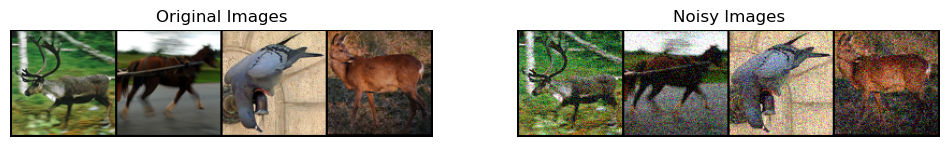

In [93]:
# Get a batch of training data
images, _ = next(iter(train_loader))
noisy_images = add_gaussian_noise(images)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
imshow(torchvision.utils.make_grid(images[:4]), axes[0], 'Original Images')
imshow(torchvision.utils.make_grid(noisy_images[:4]), axes[1], 'Noisy Images')
plt.show()

<h3>Task 1: Define the U-Net Model Class <b> (10 points) </b>. </h3>

Your task is implementing a mini version of the U-Net architecture shown below.

<div style="text-align: center;">
    <img src="MiniUNet.png" alt="Image Title" style="width:500px; height:auto;"/>
</div>

**Your Task:**
- Initialize all the layers in the `__init__` method.
- Complete the `forward` method to pass the input through the layers in accordance with the architecture.

**Useful links:**

- [Conv2D in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [ReLU in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [MaxPool2D in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
- [Transpose Conv2D in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)
- [Sigmoid in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)


In [94]:
class MiniUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # can be reused in the forward as it has no parameters.

        self.enc2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.enc3= nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoding path
        self.upconv1 = nn.ConvTranspose2d(in_channels = 256, out_channels = 256, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(in_channels = 128, out_channels = 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        """ 
        This function implements the forward pass
        
        Parameters:
            x: input images of shape (batch_size, 3, 96, 96)
        Returns: 
            denoised images of shape (batch_size, 3, 96, 96)
        """
        output_enc1 = self.enc1(x)
        output_pool1 = self.pool(output_enc1)
        output_enc2 = self.enc2(output_pool1)
        output_pool2 = self.pool(output_enc2)
        output_enc3 = self.enc3(output_pool2)

        output_upconv1 = self.upconv1(output_enc3)
        output_dec1 = self.dec1(output_upconv1)
        output_upconv2 = self.upconv2(output_dec1)
        output_dec2 = self.dec2(output_upconv2)
        output_dec3 = self.dec3(output_dec2)

        return output_dec3

**Test the correctness of your model by running the cell below**

In [95]:
# test the model definition
all_tests_successful = True
conv2d_count, upconv2d_count=0, 0

model = MiniUNet()
for layer in model.modules():
    if isinstance(layer, nn.Conv2d):
        conv2d_count += 1
    if isinstance(layer, nn.ConvTranspose2d):
        upconv2d_count += 1
        
dummy_input = torch.randn(1, 3, 96, 96)
dummy_output = model(dummy_input)

if dummy_output.shape != (1,3,96,96):
    all_tests_successful = False
    raise AssertionError(f"Expected output shape(1, 3, 96, 96), instead got {dummy_output.shape}.")

if conv2d_count != 6:
    all_tests_successful = False
    raise AssertionError(f"Expected 6 Conv2d layers, got {conv2d_count}.")
    
if upconv2d_count != 2:
    all_tests_successful = False
    raise AssertionError(f"Expected 2 ConvTranspose2d layers, got {upconv2d_count}.")

if not torch.all((dummy_output >= 0) & (dummy_output <= 1)):
    raise AssertionError("The output is not within the expected range [0, 1]. Sigmoid might be missing.")

if all_tests_successful: 
    success_str = "Good job! All visible tests passed! You can proceed further."
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed! You can proceed further.


In [96]:
# This cell contains hidden test cases that will be evaluated after submission. DO NOT DELETE THE CELL.

<h3> Task 2: Define the loss function and optimizer. <b> (2 Points) </b></h3>

you will implement the `loss_and_optimizer` function, which is essential for training your convolutional neural network (CNN). Follow these guidelines to complete this function:

1. **Choose the Loss Function**: 
   - Since this exercise involves image denoising, the goal is to minimize the difference between the denoised output and the original clean image. 
   - A common choice for this task is the Mean Squared Error (MSE) loss, which measures the average squared difference between the predicted and target values.
   - [Refer: MSE loss in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)

2. **Select the Optimizer**: 
   - An optimizer is used to update the model parameters based on the loss function. 
   - The Adam optimizer is widely used for its efficiency and effectiveness in handling large datasets and complex models. Initialize the Adam optimizer and set the learning rate to 0.001 to control the step size during optimization.
   - [Refer: Adam optimizer in PyTorch](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)

3. **Return Both Components**: 
   - Your function should return both the loss criterion and the optimizer.


In [97]:
def loss_and_optimizer(model):
    """
    This function initializes and returns the loss criterion and optimizer for training a CNN model.

    Parameters:
    model: The model to be trained.

    Returns:
    tuple: A tuple containing:
        -  The loss function (Mean Squared Error loss).
        -  The optimizer (Adam) for updating model parameters.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    return criterion, optimizer

In [98]:
model = MiniUNet()
criterion, optimizer = loss_and_optimizer(model)

model = model.to(device) 
criterion = criterion.to(device)

**Test the correctness of your loss_and_optimizer function by running the cell below**

In [99]:
# This cell tests the correctness of loss function and optimizer 
all_tests_successful = True

if not isinstance(criterion, nn.MSELoss):
    all_tests_successful = False
    raise AssertionError("The criterion is not set properly to MSE loss.")

model_params = list(model.parameters())
optimizer_params = [param for param_group in optimizer.param_groups for param in param_group['params']]
if model_params != optimizer_params:
    all_tests_successful = False
    raise AssertionError("The optimizer does not contain the model parameters")

    
if all_tests_successful:
    success_str = "Good job! All visible tests passed!"
    print(f"\033[92m{success_str}\033[0m")

Good job! All visible tests passed!


In [100]:
# This cell contains hidden test cases that will be evaluated after submission

<h3> Task 3: Training loop. <b>(4 points)</b></h3>

In this step, we will implement the training loop for our U-Net model. The training loop is where the model learns from the training data by adjusting its weights based on the loss function.

#### Key Components of the Training Loop:

- `num_epochs = 10`: This specifies the number of times the entire training dataset will pass through the model. You can adjust this number based on your needs and computational resources.
- `model.train()`: Sets the model to training mode, which activates certain layers (like dropout) that are only active during training.
- `for epoch in range(num_epochs)`: Iterates over the specified number of epochs.
   
- `for i, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"))`: Loops through batches of training data, with a progress bar showing the current epoch and batch.
- `noisy_images = add_gaussian_noise(images)`: Applies Gaussian noise to the images to simulate noisy inputs.

**Your task is to complete the train function using the guidelines below:**

- set the gradients to zero.
- pass the input to the model to get the predictions.
- calculate the MSE error between the predicted image and the label.
- calculate the gradients with respect to the loss.
- update the model weights using the optimizer.
- append the loss value to the `epoch_loss` list for every iteration.




In [101]:
# Training loop

def train(model, optimizer, criterion, train_loader, num_epochs=10, verbose=True): 
    """ 
    Function to train the model.
    
    Parameters: 
    - model: The model to train.
    - optimizer: The optimizer for updating model parameters.
    - criterion: The loss function to use.
    - train_loader: DataLoader for training data.
    - num_epochs: Number of training epochs (default is 10).
    - verbose: Boolean: print training progress and loss (default is True) 
    """
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = []                                  # Append the loss of every iteration to the epoch loss
        for i, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", disable=not verbose)):
            
            images = images.to(device)                  # Move the input to 'device' (CPU or GPU)
            noisy_images = add_gaussian_noise(images)   # Add Gaussian noise to simulate noisy images

            outputs = model(noisy_images)
            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(epoch_loss):.4f}') 

**Test the correctness of your train function by running the cell below**

In [102]:
# This cell tests the training code
all_tests_successful = True

from unittest.mock import patch, MagicMock
mock_train_loader = MagicMock()
mock_train_loader.__iter__.return_value = [(torch.rand(8, 3, 96, 96), None)]

with patch('torch.Tensor.backward') as mock_backward, patch.object(optimizer, 'step') as mock_step:
    
    train(model, optimizer, criterion, mock_train_loader, num_epochs=1, verbose=False)
    
    if mock_backward.called:   # check if .backward() was called
        pass
    else:
        all_tests_successful = False
        raise AssertionError("You forgot to calculate the gradients.")

    if mock_step.called: # check if .step() is used
        pass
    else:
        all_tests_successful = False
        raise AssertionError("You forgot to update the weights.")
    
if all_tests_successful:
    success_str = 'Good job! you can now proceed to train your model.'
    print(f"\033[92m{success_str}\033[0m")
    

Good job! you can now proceed to train your model.


In [103]:
# This cell contains hidden test cases that will be evaluated after submission

In [104]:
num_epochs = 20
if not skip_training:
    train_loss = train(model, optimizer, criterion, train_loader, num_epochs)
    torch.save(model.state_dict(), 'best_model.pth')
    print("Your trained model is saved successfully!")
else:
    model.load_state_dict(torch.load('best_model.pth', map_location=device))
    print("Loaded weights from your saved model successfully!")

Loaded weights from your saved model successfully!


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19168\985530687.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_locatio

<h3>Task 4: Testing Loop. <b> (4 points) </b></h3>
In this step, we will evaluate the performance of the trained U-Net model on the test dataset. The testing loop is used to assess how well the model performs on unseen data.

#### Key Components of the Testing Loop:

- `model.eval()`: Sets the model to evaluation mode. This is important because it deactivates certain layers that behave differently during training (e.g., batch normalization layers, dropout layers).

**Your task**:
   - Complete the `test` function below using the `train` function as a reference. Think about which steps from the `train` function are necessary and which are not.
   - Check PyTorch documentation to figure out if there are any ways to reduce memory consumption during inference.

In [105]:
# Testing loop
def test(model, criterion, test_loader):
    """ 
    Function to test the model.
    
    Parameters: 
    - model: The model to test.
    - criterion: The loss function to calculate test loss.
    - test_loader: DataLoader for testing data.
    """
    model.eval()
    test_loss = []

    # with torch.no_grad():
    for i, (images, _) in enumerate(tqdm(test_loader)):
        
        # images = images.to(device)                  # Move the input to 'device' (CPU or GPU)
        noisy_images = add_gaussian_noise(images)   # Add Gaussian noise to simulate noisy images

        outputs = model(noisy_images)

        loss = criterion(outputs, images)
        test_loss.append(loss.item())
        
    return np.mean(test_loss)

In [106]:
test_loss = test(model, criterion, test_loader)
print(f'Test loss: {test_loss:.4f}')

100%|██████████| 125/125 [00:20<00:00,  6.04it/s]

Test loss: 0.0017


**Test the correctness of your test function by running the cell below**

In [107]:
# This cell contains visible test cases for the 'test' function
all_tests_successful = True

from unittest.mock import patch, MagicMock
mock_test_loader = MagicMock()
mock_test_loader.__iter__.return_value = [(torch.rand(8, 3, 96, 96).to(device), None)]

if test_loss < 0.002:
    pass
else:
    all_tests_successful = False
    raise AssertionError(f"Expected test loss to be less than 0.002 but got {test_loss}." )
    
with patch('__main__.add_gaussian_noise') as mock_add_noise, patch.object(optimizer, 'zero_grad') as mock_zero_grad, patch.object(optimizer, 'step') as mock_step:
    
    mock_add_noise.return_value = torch.rand(8,3,96,96).to(device)
    _ = test(model, criterion, mock_test_loader)  

    if mock_add_noise.called:
        pass
    else:
        all_tests_successful = False
        raise AssertionError("Did you add noise to the images before passing it to the model?" )
          
    if not mock_zero_grad.called and not mock_step.called:  # check is optimizers are not used
        pass
    else:
        all_tests_successful = False
        raise AssertionError("Think about the purpose of optimizers during inference.")


hidden_test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
hidden_test_loss = test(model, criterion, hidden_test_loader)

if round(hidden_test_loss, 4) == round(test_loss, 4):
    pass
else:
    all_tests_successful = False
    print(test_loss, hidden_test_loss)
    raise AssertionError("Suspicious! Check if test loader was changed.")
    
if all_tests_successful:
    success_str = 'Great job! You passed all the visible test cases!'
    print(f"\033[92m{success_str}\033[0m")


1it [00:00,  7.21it/s]
100%|██████████| 125/125 [00:20<00:00,  6.24it/s]

Great job! You passed all the visible test cases!


In [108]:
# This cell contains hidden test cases that will be evaluated after submission

In [109]:
def visualize_results(model, test_loader):
    """
    Function to visualize the denoiser
    Parameters:
    - model: The model to use for denoising
    - test_loader: The DataLoader for testing data
    """

    # get one batch of images
    images, _ = next(iter(test_loader))
    images = images.to(device)

    # Add Gaussian noise
    noisy_images = add_gaussian_noise(images)

    #Forward pass to get the denoised images
    with torch.no_grad():
        outputs = model(noisy_images)

    # Display original, noisy, and denoised images
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))               
    axs[0].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
    axs[0].set_title('Original')
    axs[1].imshow(np.transpose(noisy_images[0].cpu().numpy(), (1, 2, 0)))
    axs[1].set_title('Noisy')
    axs[2].imshow(np.transpose(outputs[0].cpu().numpy(), (1, 2, 0)))
    axs[2].set_title('Denoised')
    plt.show()
    return

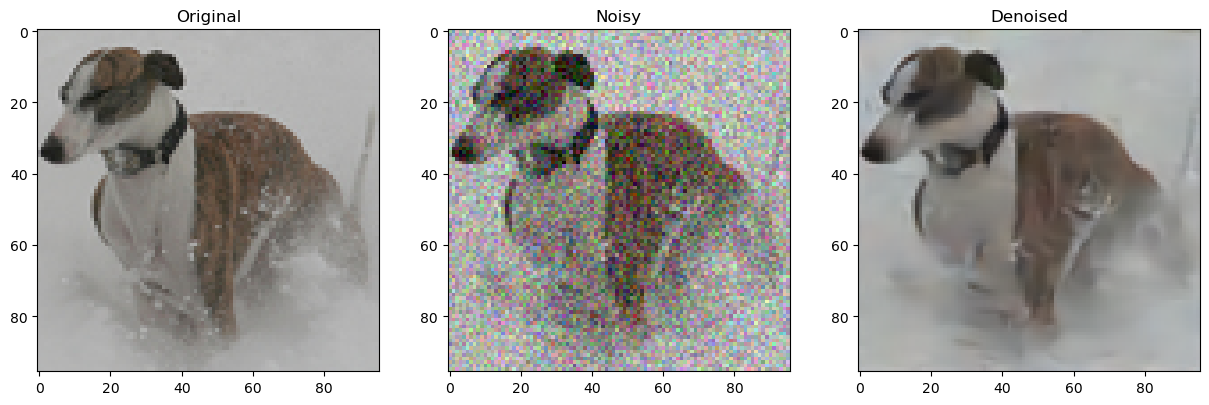

In [110]:
# visualize the results. You can run this cell multiple times to see different test images.
visualize_results(model, test_loader)

In [111]:
# Do not delete this cell